In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug 18 22:56:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.09       Driver Version: 457.09       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:08:00.0  On |                  N/A |
| 29%   35C    P8    16W / 190W |    763MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### 파이토치 이미지 학습 템플릿
1. 데이터 정의 (데이터셋 구축 / 데이터 변환 및 전처리 / 데이터 로더 생성)
    - 데이터 로더 직접 만들기 (DataLoader class inherit)

2. 모델 (기존 모델 import / 모델 직접 짜보기)
    - 모델 직접 짜보기
    - 기존 모델 class inherit -> forward method override
    - Transfer Learning 
    
3. 훈련/평가 (loss 측정 / test data 확인 )
    - loss (값 모니터링 / 시각화 )
    - save checkpoints (정해진 epoch 마다 모델 가중치 저장) 
    - check test-data accuracy (한 번도 보지 못한 데이터)

#### 라이브러리

In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
dir(DataLoader)

['_DataLoader__initialized',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_get_iterator',
 '_index_sampler',
 'check_worker_number_rationality',
 'multiprocessing_context']

In [ ]:
DataLoader

torch.utils.data.dataloader.DataLoader

In [ ]:
# 소스코드 보기 
import inspect
print(inspect.getsource(torch.utils.data.DataLoader))

class DataLoader(Generic[T_co]):
    r"""
    Data loader. Combines a dataset and a sampler, and provides an iterable over
    the given dataset.

    The :class:`~torch.utils.data.DataLoader` supports both map-style and
    iterable-style datasets with single- or multi-process loading, customizing
    loading order and optional automatic batching (collation) and memory pinning.

    See :py:mod:`torch.utils.data` documentation page for more details.

    Args:
        dataset (Dataset): dataset from which to load the data.
        batch_size (int, optional): how many samples per batch to load
            (default: ``1``).
        shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: ``False``).
        sampler (Sampler or Iterable, optional): defines the strategy to draw
            samples from the dataset. Can be any ``Iterable`` with ``__len__``
            implemented. If specified, :attr:`shuffle` must not be specified.
       

In [ ]:
print(inspect.getmembers(torch.utils.data.DataLoader))

[('_DataLoader__initialized', False), ('__annotations__', {'dataset': torch.utils.data.dataset.Dataset[+T_co], 'batch_size': typing.Union[int, NoneType], 'num_workers': <class 'int'>, 'pin_memory': <class 'bool'>, 'drop_last': <class 'bool'>, 'timeout': <class 'float'>, 'sampler': <class 'torch.utils.data.sampler.Sampler'>, 'prefetch_factor': <class 'int'>, '_iterator': typing.Union[ForwardRef('_BaseDataLoaderIter'), NoneType]}), ('__class__', <class 'type'>), ('__class_getitem__', <bound method Generic.__class_getitem__ of <class 'torch.utils.data.dataloader.DataLoader'>>), ('__delattr__', <slot wrapper '__delattr__' of 'object' objects>), ('__dict__', mappingproxy({'__module__': 'torch.utils.data.dataloader', '__annotations__': {'dataset': torch.utils.data.dataset.Dataset[+T_co], 'batch_size': typing.Union[int, NoneType], 'num_workers': <class 'int'>, 'pin_memory': <class 'bool'>, 'drop_last': <class 'bool'>, 'timeout': <class 'float'>, 'sampler': <class 'torch.utils.data.sampler.Sam

#### 1. 데이터 정의

#### A. 데이터셋 구축 / 전처리

In [ ]:
# 이미지 변환
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

#### B. 데이터로더 생성

In [ ]:
os.getcwd()

'/content'

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 데이터 까지의 경로
os.listdir('./gdrive/MyDrive/Colab_Notebooks/data/')

['Mondeique_Open_train.csv',
 'Mondeique_Open_test.csv',
 'imagewoof2',
 'imagenette2',
 'imagenette2.tgz']

In [ ]:
# 데이터 셋은 아래 링크로 받으실 수도 있습니다!
# https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

In [ ]:
# 데이터 복붙 후 압축 풀기
# GDrive 에 올린 압축 푼 데이터를 사용하는 거 보다 빠름

from google.colab import output

DATA_ZIP_PATH = '/content/gdrive/MyDrive/Colab_Notebooks/data/'

# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/MyDrive/Colab_Notebooks/data/imagenette2.tgz" "imagenette2.tgz"
# imagenette2.zip을 현재 디렉터리에 압축해제
!tar -xvzf "imagenette2.tgz"

# 출력 결과 지우기
output.clear()

In [ ]:
# 폴더명 클래스 이름으로 변경
!mv "./imagenette2/train/n01440764" "./imagenette2/train/tench"
!mv "./imagenette2/train/n02102040" "./imagenette2/train/English_springer"
!mv "./imagenette2/train/n02979186" "./imagenette2/train/cassette_player"
!mv "./imagenette2/train/n03000684" "./imagenette2/train/chain_saw"
!mv "./imagenette2/train/n03028079" "./imagenette2/train/church"
!mv "./imagenette2/train/n03394916" "./imagenette2/train/French_horn"
!mv "./imagenette2/train/n03417042" "./imagenette2/train/garbage_truck"
!mv "./imagenette2/train/n03425413" "./imagenette2/train/gas_pump"
!mv "./imagenette2/train/n03445777" "./imagenette2/train/golf_ball"
!mv "./imagenette2/train/n03888257" "./imagenette2/train/parachute"

!mv "./imagenette2/val/n01440764" "./imagenette2/val/tench"
!mv "./imagenette2/val/n02102040" "./imagenette2/val/English_springer"
!mv "./imagenette2/val/n02979186" "./imagenette2/val/cassette_player"
!mv "./imagenette2/val/n03000684" "./imagenette2/val/chain_saw"
!mv "./imagenette2/val/n03028079" "./imagenette2/val/church"
!mv "./imagenette2/val/n03394916" "./imagenette2/val/French_horn"
!mv "./imagenette2/val/n03417042" "./imagenette2/val/garbage_truck"
!mv "./imagenette2/val/n03425413" "./imagenette2/val/gas_pump"
!mv "./imagenette2/val/n03445777" "./imagenette2/val/golf_ball"
!mv "./imagenette2/val/n03888257" "./imagenette2/val/parachute"

In [ ]:
# Load the Data
dataset = 'imagenette2'

# Set train and valid directory paths
train_directory = './imagenette2/train'
# train dataset을 나눠서 train & val 로 활용하고
# 주어진 val 은 test 로 활용함
test_directory = './imagenette2/val'

# Batch size
bs = 32 

# Number of classes
num_classes = len(os.listdir(train_directory))  #10
print(num_classes)

# Load Data from folders
# 일단 같은 train_directory로 'train' & 'valid' dataset을 불러오지만
# 이후 과정에서 Subset과 적절한 indexing으로 둘을 깔끔하게 분리해줄 것임
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=train_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

10
{0: 'English_springer', 1: 'French_horn', 2: 'cassette_player', 3: 'chain_saw', 4: 'church', 5: 'garbage_truck', 6: 'gas_pump', 7: 'golf_ball', 8: 'parachute', 9: 'tench'}


In [ ]:
# just checking size for each class in train dataset
print(len(os.listdir(train_directory+'/English_springer/')))
print(len(os.listdir(train_directory+'/French_horn/')))
print(len(os.listdir(train_directory+'/cassette_player/')))
print(len(os.listdir(train_directory+'/chain_saw/')))
print(len(os.listdir(train_directory+'/church/')))
print(len(os.listdir(train_directory+'/garbage_truck/')))
print(len(os.listdir(train_directory+'/gas_pump/')))
print(len(os.listdir(train_directory+'/golf_ball/')))
print(len(os.listdir(train_directory+'/parachute/')))
print(len(os.listdir(train_directory+'/tench/')))

955
956
993
858
941
961
931
951
960
963


In [ ]:
# trying to do stratified split without scikitlearn
import random
full_idx = list(range(9469))
val_idx = random.sample(range(955), int(955/5))
val_idx += random.sample(range(955, 955+956), int(956/5))
val_idx += random.sample(range(955+956, 955+956+993), int(993/5))
val_idx += random.sample(range(955+956+993, 955+956+993+858), int(858/5))
val_idx += random.sample(range(955+956+993+858, 955+956+993+858+941), int(941/5))
val_idx += random.sample(range(955+956+993+858+941, 955+956+993+858+941+961), int(961/5))
val_idx += random.sample(range(955+956+993+858+941+961, 955+956+993+858+941+961+931), int(931/5))
val_idx += random.sample(range(955+956+993+858+941+961+931, 955+956+993+858+941+961+931+951), int(951/5))
val_idx += random.sample(range(955+956+993+858+941+961+931+951, 955+956+993+858+941+961+931+951+960), int(960/5))
val_idx += random.sample(range(955+956+993+858+941+961+931+951+960, 955+956+993+858+941+961+931+951+960+963), int(963/5))
val_idx.sort()
train_idx = [idx for idx in full_idx if idx not in val_idx] 
# created 20% of val index for each class
# taking advantage of the fact that Dataset has indexing in order
# even though shuffle=True

In [ ]:
# just checking
print(len(val_idx))
print(len(train_idx))
print(len(val_idx) + len(train_idx))
print(len(full_idx))

1891
7578
9469
9469


In [ ]:
from torch.utils.data import Subset

In [ ]:
data['train'] = Subset(data['train'], train_idx)
data['valid'] = Subset(data['valid'], val_idx)

In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=False)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

#### 데이터 로더 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


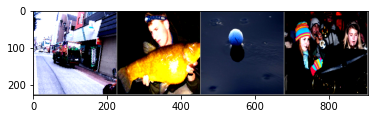

garbage_truck tench golf_ball French_horn


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images

trainloader_1 = DataLoader(data['train'], batch_size=4, shuffle=True)

dataiter = iter(trainloader_1)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % list(idx_to_class.values())[labels[j]] for j in range(4)))

# ㅎㅎ 일단 사진을 확인할 수 있따니 뿌듯

In [ ]:
del trainloader_1

#### 훈련 데이터, 검증 데이터 / 테스트 데이터

In [ ]:
train_data_size, valid_data_size, test_data_size

(7578, 1891, 3925)

#### 2. 모델

#### Scratch 방식

In [ ]:
# 1. 코드를 직접 짜 보셔도 되고 2. 기존의 코드를 inherit 해도 됩니다

# 예시 
class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=0)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=0)
        self.avgpool = nn.AvgPool2d(kernel_size=6)
        self.linear = nn.Linear(512,10)

        
    def forward(self, x):
        # change forward here
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = F.relu(x)

        #print(x.size())
        x = self.avgpool(x)

        x = x.view(-1,512)
        #print(x.size())

        x = self.linear(x)
    
        output = F.log_softmax(x, dim=1)

        return output

mymodel = MyModel()
mymodel = mymodel.to('cuda:0')

#### Trasnfer Learning with ResNet50
- 다른 모델도 많이 있습니다

In [ ]:
import inspect 
print(inspect.getsource(torchvision.models))

from .alexnet import *
from .resnet import *
from .vgg import *
from .squeezenet import *
from .inception import *
from .densenet import *
from .googlenet import *
from .mobilenet import *
from .mnasnet import *
from .shufflenetv2 import *
from . import segmentation
from . import detection
from . import video
from . import quantization



In [ ]:
# Load pretrained ResNet18 Model
resnet18 = models.resnet18(pretrained=True) # transfer learning
resnet18.to('cuda:0')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(resnet18, input_size=(3, 224, 224),  device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# transfer 하기 위해 pretrained 가중치 freeze
# Freeze model parameters
for param in resnet18.parameters():
    param.requires_grad = False

In [ ]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet18.fc.in_features # FC layer ResNet

resnet18.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet18 = resnet18.to('cuda:0')

#### Loss Function, Optimizer 정의

In [ ]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet18.parameters())

In [ ]:
# # Define Optimizer and Loss Function
# loss_func = nn.NLLLoss()
# optimizer = optim.Adam(mymodel.parameters())

#### 3. 훈련 / 평가
- train_and_validate
- computeTestSetAccuracy
- predict

In [ ]:
iter(train_data_loader).__next__()

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            if i%50==0 and i != 0:
                print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            torch.save(model, dataset+'_model_'+str(epoch))
            
    return model, history

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model for 20 epochs
num_epochs = 3
trained_model, history = train_and_validate(resnet18, loss_func, optimizer, num_epochs)      

torch.save(history, dataset+'_history.pt')

Epoch: 1/3
Batch number: 050, Training: Loss: 0.0813, Accuracy: 1.0000
Batch number: 100, Training: Loss: 0.1189, Accuracy: 1.0000
Batch number: 150, Training: Loss: 0.1124, Accuracy: 0.9375
Batch number: 200, Training: Loss: 0.4300, Accuracy: 0.8125
Epoch : 000, Training: Loss: 0.3521, Accuracy: 90.0501%, 
		Validation : Loss : 0.0677, Accuracy: 98.0962%, Time: 110.6647s
Epoch: 2/3
Batch number: 050, Training: Loss: 0.1191, Accuracy: 0.9688
Batch number: 100, Training: Loss: 0.0929, Accuracy: 0.9688
Batch number: 150, Training: Loss: 0.1475, Accuracy: 0.9062
Batch number: 200, Training: Loss: 0.2492, Accuracy: 0.9062
Epoch : 001, Training: Loss: 0.1596, Accuracy: 94.9723%, 
		Validation : Loss : 0.0620, Accuracy: 98.0962%, Time: 110.3075s
Epoch: 3/3
Batch number: 050, Training: Loss: 0.0461, Accuracy: 1.0000
Batch number: 100, Training: Loss: 0.0834, Accuracy: 0.9688
Batch number: 150, Training: Loss: 0.1736, Accuracy: 0.9688
Batch number: 200, Training: Loss: 0.1352, Accuracy: 0.9375

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Train the model for 20 epochs
# num_epochs = 3
# trained_model, history = train_and_validate(mymodel, loss_func, optimizer, num_epochs)      

# torch.save(history, dataset+'_history.pt')

#### Loss 관찰

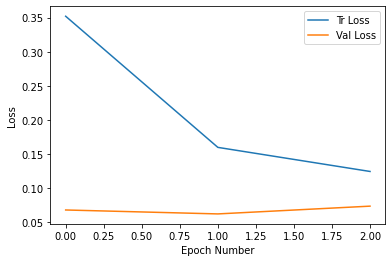

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig(dataset+'_loss_curve.png')
plt.show()

#### Accuracy 관찰

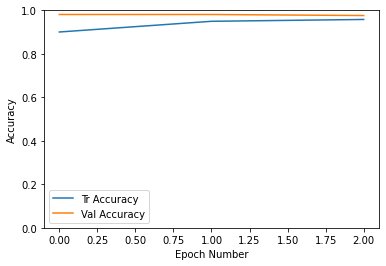

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

#### Test Set Accuracy

In [ ]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)
            if j%50==0 and j!=0:
                print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

#### Prediction 수행

In [ ]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        # 합이 1이 되는 softmax로 변환
        softmax = ps/torch.sum(ps)
        topk, topclass = softmax.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Test Batch number: 050, Test: Loss: 0.0207, Accuracy: 1.0000
Test Batch number: 100, Test: Loss: 0.2318, Accuracy: 0.9375
Test accuracy : 0.9814012738853504
Predcition 1 : English_springer , Score:  0.9998244
Predcition 2 : golf_ball , Score:  4.974362e-05
Predcition 3 : French_horn , Score:  4.939809e-05


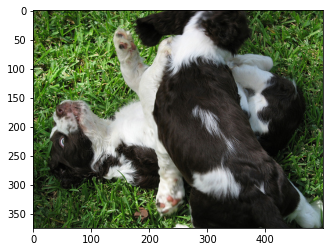

In [ ]:
dataset = 'imagenette2'

# 디렉토리에 저장된 모델 이름 한 번 확인해보세요!
model = torch.load(f'{dataset}_model_0')
loss_criterion = nn.NLLLoss()
computeTestSetAccuracy(model, loss_criterion)
predict(model, '/content/imagenette2/val/English_springer/ILSVRC2012_val_00004650.JPEG')

In [ ]:
# dataset = 'imagenette2'
# model = torch.load(f'{dataset}_model_2')
# loss_criterion = nn.NLLLoss()
# computeTestSetAccuracy(model, loss_criterion)
# predict(model, '/content/imagenette2/val/English_springer/ILSVRC2012_val_00004650.JPEG')